In [1]:

 # To mount Google Drive
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import re

df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/ocsvm_results.csv')
print("Original Size of dataset: {}".format(len(df)))

profiles_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/consolidated_profiles.csv')
print("Original number of users: {}".format(len(profiles_df)))

products_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/consolidated_product_info.csv')
print("Original number of products: {}".format(len(products_df)))

filtered_df = df[df['fake_reviews'] == 1]
suspicious_users = list(set(filtered_df['acc_num']))
print("Number of suspicious users: {}".format(len(suspicious_users)))

filtered_df = df[df['acc_num'].isin(suspicious_users)]
print("Size of dataset with fake reviews: {}".format(len(filtered_df)))

Original Size of dataset: 77268
Original number of users: 65930
Original number of products: 102
Number of suspicious users: 12298
Size of dataset with fake reviews: 16114


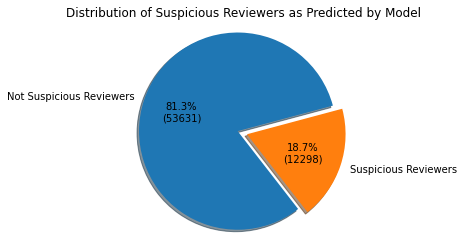

In [3]:
import matplotlib.pyplot as plt

# # Creating plot 
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

non_suspicious_users = len(profiles_df) -  len(suspicious_users)

my_explode = (0, 0.1)
plt.pie([non_suspicious_users, len(suspicious_users)],labels=['Not Suspicious Reviewers','Suspicious Reviewers'],autopct=lambda pct: func(pct, [non_suspicious_users, len(suspicious_users)]),startangle=15, shadow = True, explode=my_explode)
plt.title("Distribution of Suspicious Reviewers as Predicted by Model")
plt.axis('equal')
plt.show()

In [4]:
import networkx as nx

def build_graph(df):
    slack_graph = nx.from_pandas_edgelist(df,source='user1',target='user2', edge_attr='weights', create_using=nx.Graph())

    return slack_graph  

try:
    network_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/suspicious_users_network.csv')
except:
    !pip install --upgrade rgmining-fraud-eagle

    import fraud_eagle as feagle

    # Create a graph with a parameter `epsilon`.
    epsilon = 0.1
    graph = feagle.ReviewGraph(epsilon)

    reviewers = {}
    for reviewer in set(filtered_df['acc_num']):
        reviewers[reviewer] = graph.new_reviewer(reviewer)

    products = {}
    for product in set(filtered_df['asin']):
        products[product] = graph.new_product(product)

    for reviewer, product, rating in zip(filtered_df['acc_num'], filtered_df['asin'],filtered_df['cleaned_reviews_ratings']):
        graph.add_review(reviewers[reviewer], products[product], rating)

    max_iteration = 10000
    for i in range(max_iteration):

        # Run one iteration.
        diff = graph.update()
        print("Iteration {}...Difference={}".format(i + 1, diff))

        if diff < 10**-5: # Set 10^-5 as an acceptable small number.
            print("Difference is significantly small...Stopping Iteration...")
            break
    top_users = [r.name for r in graph.reviewers if r.anomalous_score >= 0.9]
    print(top_users)
    print(len(top_users))

    build_network = {"user1":[],"user2":[],"weights":[]}
    for i,user1 in enumerate(top_users):
        products_for_user1 = list(filtered_df[filtered_df['acc_num'] == user1]['asin'])
        for user2 in top_users[1:]:
            if user1 != user2:
                products_for_user2 = list(filtered_df[filtered_df['acc_num'] == user2]['asin'])
                overlap_products = list(set(products_for_user1) & set(products_for_user2))
                if len(overlap_products) >= 2:
                    build_network['user1'].append(user1)
                    build_network['user2'].append(user2)
                    build_network['weights'].append(len(overlap_products))
        print("Current Iteration: {}/{}".format(i+1,len(top_users)))
        print("Current Dataset size: {}...\n".format(len(build_network['user1'])))

    network_df = pd.DataFrame.from_dict(build_network)
    user1_names = []
    user2_names = []
    for index, row in network_df.iterrows():
        user1_name = str(list(profiles_df.loc[profiles_df['acc_num'] == row['user1'],'name'])[0])
        user2_name = str(list(profiles_df.loc[profiles_df['acc_num'] == row['user2'],'name'])[0])
        user1_names.append(user1_name)
        user2_names.append(user2_name)

    deleted_users = ['Amazon user', 'Amazon Customer']
    network_df['user1_name'] = user1_names
    network_df['user2_name'] = user2_names
    network_df = network_df[(~network_df['user1_name'].isin(deleted_users)) & (~network_df['user2_name'].isin(deleted_users))]
    print("New Length of Network Dataset after keeping interested nodes: {}".format(len(network_df)))
    display(network_df)

    interested_graph = build_graph(network_df)
    network_df.to_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/suspicious_users_network.csv',index=False)
print("Original Length of Network Dataset: {}".format(len(network_df)))

print("New Length of Network Dataset after filtering number of overlap history >= 2: {}".format(len(network_df)))
display(network_df)


Original Length of Network Dataset: 7846
New Length of Network Dataset after filtering number of overlap history >= 2: 7846


,user1,user2,weights,user1_name,user2_name
0,AHWPMJSDVJV4XGIMTJC4D5X6BULQ,AEKJS2XKC6HGWF2DKP2CVNGRQS7Q,2,charlotte adams,Katie
1,AHWPMJSDVJV4XGIMTJC4D5X6BULQ,AEWBKNFOD23CNKCEJ734MSGJYOCA,2,charlotte adams,Tiffinie Allen
2,AHWPMJSDVJV4XGIMTJC4D5X6BULQ,AE7DAMWN4OFY7CMWDEXAT34S7NBA,2,charlotte adams,Sonya Russell
3,AHWPMJSDVJV4XGIMTJC4D5X6BULQ,AGSDK67WGYHBDXCT6M7DADN2UHIQ,2,charlotte adams,Nance
4,AHWPMJSDVJV4XGIMTJC4D5X6BULQ,AETRIOSGYHZCH42IAOP4SGBFDIXA,2,charlotte adams,2006
...,...,...,...,...,...
7841,AGOWLMW2UQCKVHKXKOAQFQ6GAWMQ,AGRYYEFOOMCSBGWGER42NIXET5EQ,2,tabasco cat,Daniel T.
7842,AGOWLMW2UQCKVHKXKOAQFQ6GAWMQ,AG5MIMX4XJE2RHPD2PJBTY2LOQMQ,2,tabasco cat,Sue B Dodson
7843,AGOWLMW2UQCKVHKXKOAQFQ6GAWMQ,AFJCDZIN24HLRMA5FX7X4QE4RT2A,2,tabasco cat,Maria Fattizzi
7844,AGOWLMW2UQCKVHKXKOAQFQ6GAWMQ,AHMFON65SFJUNPHMMZZLB6UTI7VQ,2,tabasco cat,honeybunny4989


In [5]:
import plotly.graph_objects as go
from networkx.algorithms.centrality import *
import networkx as nx
import pandas as pd

def build_graph(df):
    slack_graph = nx.from_pandas_edgelist(df,source='user1',target='user2', edge_attr='weights', create_using=nx.Graph())

    return slack_graph  

def visualize_graph(graph,network_df):
    pos = nx.spring_layout(graph,k=10, iterations=1000)

    edge_x = []
    edge_y = []
    for edge in graph.edges():
        from_edge = edge[0]
        to_edge = edge[1]
        x0 = pos[from_edge][0]
        y0 = pos[from_edge][1]
        x1 = pos[to_edge][0]
        y1 = pos[to_edge][1]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    node_x = []
    node_y = []
    node_text = []
    for node in graph.nodes():
        x = pos[node][0]
        y = pos[node][1]
        node_x.append(x)
        node_y.append(y)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='Jet',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Betweeness Centrality',
                xanchor='left',
                titleside='right'
            ),
        line_width=2))

    reviewers_name = list(network_df['user1_name']) + list(network_df['user1_name'])
    reviewers_acc_name =  list(network_df['user1']) + list(network_df['user2'])
    reviewer_mapping = {}

    for reviewer_acc_name, reviewer_name in zip(reviewers_acc_name,reviewers_name):
        if reviewer_acc_name not in reviewer_mapping:
            reviewer_mapping[reviewer_acc_name] = reviewer_name
    node_adjacencies = []
    betweeness = betweenness_centrality(interested_graph)
    color = []
    node_text = []
    for node, adjacencies in enumerate(graph.adjacency()):
        temp_graph = graph.to_undirected()
        neighbours = list(temp_graph.neighbors(adjacencies[0]))
        neighbours = [neighbour for neighbour in neighbours if neighbour != adjacencies[0]]
        number_neighbours = len(neighbours)
        node_adjacencies.append(number_neighbours)
        color.append(betweeness[adjacencies[0]])
        node_text.append("{} has {} connections. Reviewer's Account Number is {}".format(reviewer_mapping[adjacencies[0]],number_neighbours,adjacencies[0]))

    node_trace.marker.color = color
    max_adjacencies = max(node_adjacencies)
    node_adjacencies = [max(10,20*(node_adjacency/max_adjacencies)) for node_adjacency in node_adjacencies]
    node_trace.marker.size = node_adjacencies
    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                # margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                title="Network Containing Top Suspicious Reviewers" 
                )
                )
    
    fig.update_layout(yaxis = dict(scaleanchor = "x", scaleratio = 1), plot_bgcolor='rgb(255,255,255)')
    
    return fig

interested_graph = build_graph(network_df)
fig = visualize_graph(interested_graph,network_df)
fig.show()

In [6]:
suspicious_reviewers_betweeness = betweenness_centrality(interested_graph)
suspicious_reviewers_betweeness = {key: value for (key, value) in sorted(suspicious_reviewers_betweeness.items(), key=lambda item: item[1],reverse=True) if value > 0}

print(suspicious_reviewers_betweeness)
print("Number of Suspicious Reviewers with more than 0 betweeness centrality: {}".format(len(suspicious_reviewers_betweeness)))

{'AFSCN7KTUEMGKDNWDS2LUKDMBJJQ': 0.11943584451324389, 'AE4M4BVD6UX4AM4AI5SX5HGEBHNA': 0.11943584451324389}
Number of Suspicious Reviewers with more than 0 betweeness centrality: 2


In [7]:
top_suspicious_reviewers = list(suspicious_reviewers_betweeness.keys())[:3]

In [8]:

interested_df = df[df['acc_num'].isin(top_suspicious_reviewers)]
interested_columns = ['cleaned_reviews_date_posted','asin','acc_num','cleaned_reviews_verified','cleaned_reviews_ratings','cleaned_reviews_text']
current_df = interested_df[interested_columns]
current_df = current_df.sort_values(by=['asin','cleaned_reviews_date_posted'])
current_df.columns = ['Date Posted','Product ASIN','User','Verified Purchase','Rating','Text']
display(current_df)

,Date Posted,Product ASIN,User,Verified Purchase,Rating,Text
75,12/21/2019,B01M09QQI0,AFSCN7KTUEMGKDNWDS2LUKDMBJJQ,1,0.8,need kind spoon order get product jar instead ...
18004,8/15/2017,B01M09QQI0,AE4M4BVD6UX4AM4AI5SX5HGEBHNA,1,0.4,like cream texture thick difficult apply skin ...
384,12/21/2019,B07GVCVYB9,AFSCN7KTUEMGKDNWDS2LUKDMBJJQ,1,0.2,nothing face wrinkle
3914,4/6/2020,B07GVCVYB9,AE4M4BVD6UX4AM4AI5SX5HGEBHNA,1,0.4,find serum sticky makeup wa apply tend flake b...
445,12/21/2019,B07NH5GB8D,AFSCN7KTUEMGKDNWDS2LUKDMBJJQ,1,0.8,need kind spoon order get product jar instead ...
8038,8/15/2017,B07NH5GB8D,AE4M4BVD6UX4AM4AI5SX5HGEBHNA,1,0.4,like cream texture thick difficult apply skin ...
1247,12/21/2019,B07YGB5SPC,AFSCN7KTUEMGKDNWDS2LUKDMBJJQ,1,0.2,nothing face wrinkle
4308,4/6/2020,B07YGB5SPC,AE4M4BVD6UX4AM4AI5SX5HGEBHNA,1,0.4,find serum sticky makeup wa apply tend flake b...
933,12/21/2019,B0813N81WS,AFSCN7KTUEMGKDNWDS2LUKDMBJJQ,1,0.2,nothing face wrinkle
2959,4/6/2020,B0813N81WS,AE4M4BVD6UX4AM4AI5SX5HGEBHNA,1,0.4,find serum sticky makeup wa apply tend flake b...


In [9]:
interested_network_users = network_df[(network_df['user1'].isin(top_suspicious_reviewers)) | (network_df['user2'].isin(top_suspicious_reviewers))]
all_unique_users = list(set(list(interested_network_users['user1']) + list(interested_network_users['user2'])))
unique_users = [user for user in all_unique_users if user not in top_suspicious_reviewers]
interested_user_df = profiles_df[profiles_df['acc_num'].isin(unique_users)]
display(interested_user_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,cleaned_deleted_status,reviewer_contributions,marketplace_id,locale,cleaned_ranking,cleaned_reviewer_ease_score,cleaned_average_helpfulVotes,cleaned_total_reviews_posted,cleaned_total_loreal_review,cleaned_proportion_loreal_review,cleaned_total_incentivized_review,cleaned_proportion_incentivized_review,cleaned_total_verified,cleaned_proportion_verified,cleaned_total_sample_review,cleaned_proportion_sample_review,cleaned_total_deleted_reviews,cleaned_proportion_deleted_reviews,cleaned_total_same_day_reviews,cleaned_proportion_same_day_reviews,cleaned_average_review_length,cleaned_total_product,cleaned_total_loreal_product,cleaned_proportion_loreal_product,cleaned_single_day_reviewer,cleaned_brand_monogamist,cleaned_brand_loyalist,cleaned_brand_repeater,cleaned_never_verified_reviewer,cleaned_one_hit_wonder,cleaned_take_back_reviewer,cleaned_badges
3281,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AGOWLMW2UQCKVHKXKOAQFQ6GAWMQ,tabasco cat,NaN,NaN,NaN,NaN,"1,874,382",0,"[{'id': 'amzn1.productreview.R2OYN6Q9T6ZVIH', ...",ATVPDKIKX0DER,en_US,1874382,0.72,4.6,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.6,14.3,10.0,0.0,0.0,1,0,0,0,1,0,0,0
3287,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHV7RM2H2WGBBDNA73S5PI66WNVA,queenky,NaN,NaN,NaN,NaN,"432,044",0,"[{'id': 'amzn1.productreview.RDK5XCCDLVCYN', '...",ATVPDKIKX0DER,en_US,432044,0.50,0.6,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1,23.8,10.0,0.0,0.0,1,0,0,0,1,0,0,0
3296,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AGMS23DV3PPAY7WCI2MOGHC2F6IA,Marcella Monte,NaN,NaN,NaN,NaN,"14,808,055",0,"[{'id': 'amzn1.productreview.R1KS48THV4VU1J', ...",ATVPDKIKX0DER,en_US,14808055,0.68,0.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,29.8,5.0,0.0,0.0,0,0,0,0,1,0,0,0
3369,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHCV35C4ME5QUUAKR4C6BG6S6MRQ,betty newton,NaN,NaN,NaN,NaN,"13,523,211",0,"[{'id': 'amzn1.productreview.R1JV4UNT3CANZP', ...",ATVPDKIKX0DER,en_US,13523211,0.68,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1,17.8,10.0,0.0,0.0,0,0,0,0,1,0,0,0
3373,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AGQKUTCGANH4T2JSSKD5JEEMO7RQ,debbie koss,NaN,NaN,NaN,NaN,"77,671,319",0,"[{'id': 'amzn1.productreview.R3IVH88W6VJN9W', ...",ATVPDKIKX0DER,en_US,77671319,0.44,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,16.0,10.0,0.0,0.0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58169,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHS3BDKS7DCB6Z4QI3LFYD7EQBPA,chiqui,NaN,NaN,NaN,NaN,"455,413",0,"[{'id': 'amzn1.productreview.R2U206YOBWZCF7', ...",ATVPDKIKX0DER,en_US,455413,1.00,0.5,10.0,2.0,0.2,2.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1,51.9,10.0,2.0,0.2,1,0,0,0,1,0,0,0
64830,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHEHOP5UCE6GU53SFUJZWMYM6PAQ,knlmix,Activity Director at a Retirement Community,NaN,I am a mother of 3 and grandmother to 6 wonder...,NaN,"451,708",0,"[{'id': 'amzn1.productreview.R31BGOL2BW3MGK', ...",ATVPDKIKX0DER,en_US,451708,0.76,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,28.9,10.0,0.0,0.0,1,0,0,0,1,0,0,0
64832,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHMG42EMKFHGDBGEUNLVDH4B6WKQ,Beth Beeco,NaN,NaN,NaN,NaN,"521,536",0,"[{'id': 'amzn1.productreview.R3OMK10RLLQGLQ', ...",ATVPDKIKX0DER,en_US,521536,1.00,0.2,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1,38.6,10.0,0.0,0.0,1,0,0,0,1,0,0,0
64834,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AEB57UGI7LX2XHQ5MPW2PC2KU4AQ,Dan,NaN,NaN,NaN,NaN,"409,572",0,"[{'id': 'amzn1.productreview.R2AJKVOXMGFFM6', ...",ATVPDKIKX0DER,en_US,409572,0.68,0.1,10.0,2.0,0.2,2.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.2,24.1,10.0,2.0,0.2,1,0,0,0,1,0,0,0


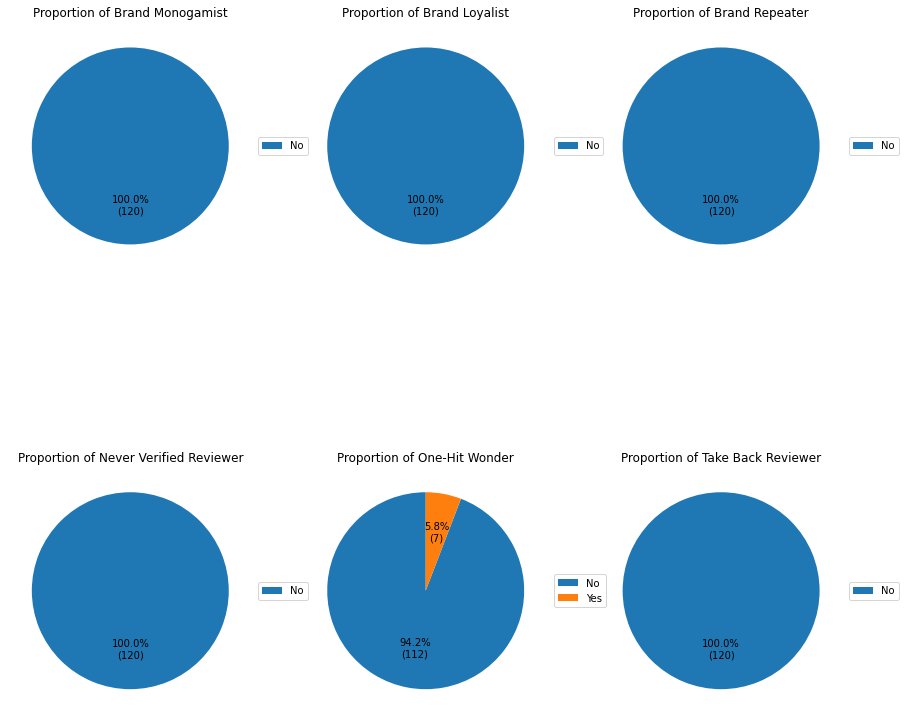

In [10]:
import matplotlib.pyplot as plt
  
reviewers_df = profiles_df[profiles_df['acc_num'].isin(all_unique_users)]

reviewers_plot_df = reviewers_df[['cleaned_brand_monogamist','cleaned_brand_loyalist','cleaned_brand_repeater','cleaned_never_verified_reviewer','cleaned_one_hit_wonder','cleaned_take_back_reviewer']]


sub_values = {'cleaned_brand_monogamist':'Brand Monogamist','cleaned_brand_loyalist':'Brand Loyalist','cleaned_brand_repeater':'Brand Repeater','cleaned_never_verified_reviewer':'Never Verified Reviewer','cleaned_one_hit_wonder':"One-Hit Wonder",'cleaned_take_back_reviewer':'Take Back Reviewer'}

fig, ax = plt.subplots(2,3, figsize=(15,15))

ax = ax.ravel()

for i, column in enumerate(reviewers_plot_df):
    temp_df = reviewers_plot_df.groupby(column).size().reset_index(name='count')
    column_values = list(temp_df['count'])
    if 0 not in list(temp_df[column]):
        column_values = [0, column_values[0]]
    elif 1 not in list(temp_df[column]):
        column_values = [column_values[0],0]
    index = ["No","Yes"]
    current_df = pd.DataFrame({index[0]: column_values[0], index[1]:column_values[1]}, index=[0])
    wedges, texts, autotexts = ax[i].pie(temp_df['count'], autopct=lambda pct: func(pct, temp_df['count']), shadow=False, startangle=90)

    ax[i].legend(wedges, index,
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))
    ax[i].set_ylabel('')
    ax[i].set_title("Proportion of {}".format(sub_values[column]))


plt.show() 

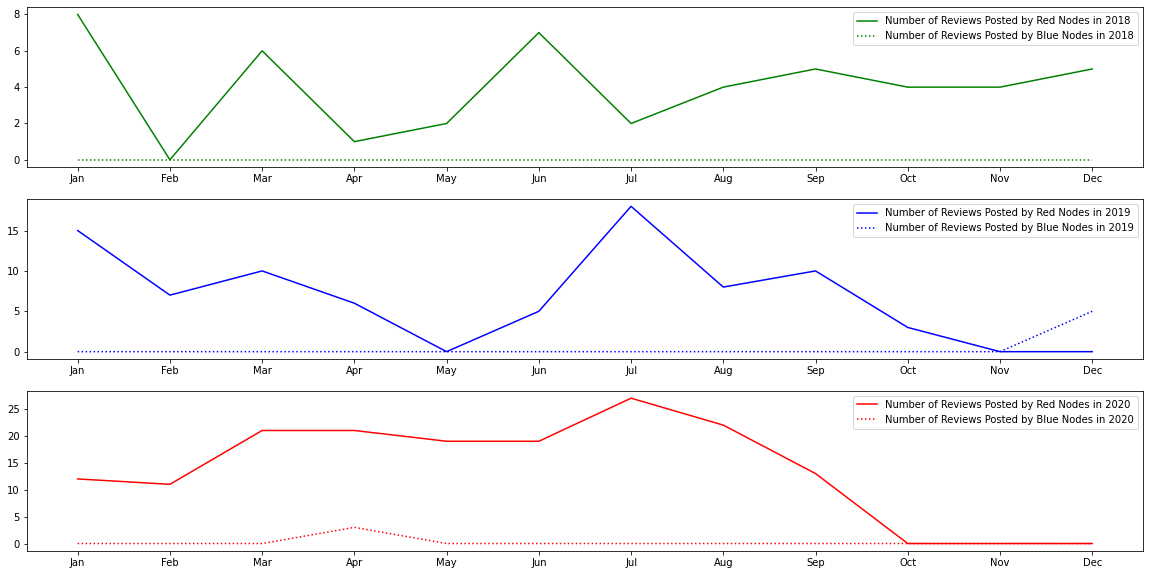

In [11]:
df['cleaned_reviews_date_posted'] = pd.to_datetime(df['cleaned_reviews_date_posted'])
df['year'] = df['cleaned_reviews_date_posted'].dt.year
df['month'] = df['cleaned_reviews_date_posted'].dt.month
clusters_df = df[df['acc_num'].isin(unique_users)]
top3_suspicious_df = df[df['acc_num'].isin(top_suspicious_reviewers)]

final_count_df = pd.DataFrame()

fig, ax = plt.subplots(3,1, figsize=(20,10))

ax = ax.ravel()

color = {0:'g',1:'b',2:'r'}
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i, year in enumerate([2018, 2019, 2020]):
    temp_clusters_df = clusters_df[clusters_df['year'] == year]
    temp_top3_suspicious_df = top3_suspicious_df[top3_suspicious_df['year'] == year]
    count_df = pd.DataFrame()
    count_df['month'] = range(1,13)
    count_clusters_df = temp_clusters_df.groupby(['month']).size().reset_index(name='count_clusters')
    count_top3_suspicious_df = temp_top3_suspicious_df.groupby(['month']).size().reset_index(name='count_reviewers')
    count_df = count_df.merge(count_clusters_df,how='left', left_on='month',right_on='month')
    count_df = count_df.merge(count_top3_suspicious_df,how='left', left_on='month',right_on='month')
    count_df['year'] = year
    count_df = count_df.fillna(0)
    final_count_df = pd.concat([final_count_df,count_df])
    ax[i].plot(months, count_df['count_clusters'],'-'+color[i],label="Number of Reviews Posted by Red Nodes in {}".format(year))
    ax[i].plot(months, count_df['count_reviewers'], ':'+color[i],label="Number of Reviews Posted by Blue Nodes in {}".format(year))
    ax[i].legend()
plt.show()

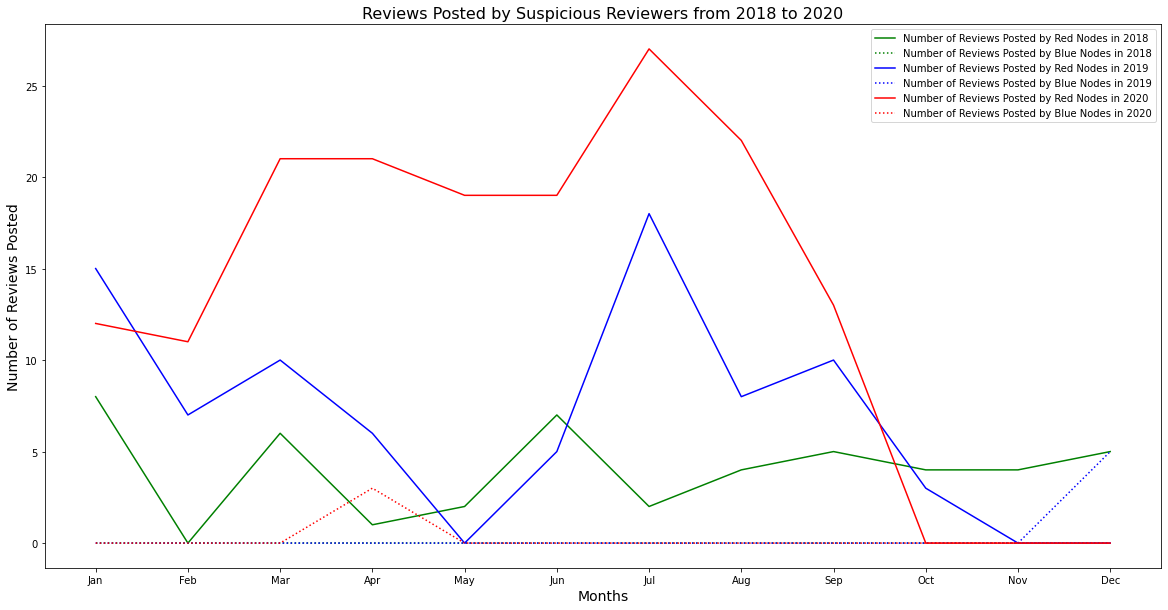

In [12]:
df['cleaned_reviews_date_posted'] = pd.to_datetime(df['cleaned_reviews_date_posted'])
df['year'] = df['cleaned_reviews_date_posted'].dt.year
df['month'] = df['cleaned_reviews_date_posted'].dt.month
clusters_df = df[df['acc_num'].isin(unique_users)]
top3_suspicious_df = df[df['acc_num'].isin(top_suspicious_reviewers)]

final_count_df = pd.DataFrame()

fig= plt.subplots(figsize=(20,10))


color = {0:'g',1:'b',2:'r'}
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i, year in enumerate([2018, 2019, 2020]):
    temp_clusters_df = clusters_df[clusters_df['year'] == year]
    temp_top3_suspicious_df = top3_suspicious_df[top3_suspicious_df['year'] == year]
    count_df = pd.DataFrame()
    count_df['month'] = range(1,13)
    count_clusters_df = temp_clusters_df.groupby(['month']).size().reset_index(name='count_clusters')
    count_top3_suspicious_df = temp_top3_suspicious_df.groupby(['month']).size().reset_index(name='count_reviewers')
    count_df = count_df.merge(count_clusters_df,how='left', left_on='month',right_on='month')
    count_df = count_df.merge(count_top3_suspicious_df,how='left', left_on='month',right_on='month')
    count_df['year'] = year
    count_df = count_df.fillna(0)
    final_count_df = pd.concat([final_count_df,count_df])
    plt.plot(months, count_df['count_clusters'],'-'+color[i],label="Number of Reviews Posted by Red Nodes in {}".format(year))
    plt.plot(months, count_df['count_reviewers'], ':'+color[i],label="Number of Reviews Posted by Blue Nodes in {}".format(year))
plt.title("Reviews Posted by Suspicious Reviewers from 2018 to 2020", fontsize=16)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Number of Reviews Posted', fontsize=14)
plt.legend()
plt.show()

In [13]:
final_count_df = pd.DataFrame()

june_2018_df = clusters_df[(clusters_df['year'] == 2018) & (clusters_df['month'] == 6) ]
july_2019_df = clusters_df[(clusters_df['year'] == 2019) & (clusters_df['month'] == 7) ]
july_2020_df = clusters_df[(clusters_df['year'] == 2020) & (clusters_df['month'] == 7) ]
june_2018_df['custom_rating'] = [rating*5 for rating in list(june_2018_df['cleaned_reviews_ratings'])]
july_2019_df['custom_rating'] = [rating*5 for rating in list(july_2019_df['cleaned_reviews_ratings'])]
july_2020_df['custom_rating'] = [rating*5 for rating in list(july_2020_df['cleaned_reviews_ratings'])]
june_2018_ratings = sum(list(june_2018_df['custom_rating']))
june_2018_reviews = len(june_2018_df)
june_2018_average_rating = june_2018_ratings/june_2018_reviews
july_2019_ratings = sum(list(july_2019_df['custom_rating']))
july_2019_reviews = len(july_2019_df)
july_2019_average_rating = july_2019_ratings/july_2019_reviews
july_2020_ratings = sum(list(july_2020_df['custom_rating']))
july_2020_reviews = len(july_2020_df)
july_2020_average_rating = july_2020_ratings/july_2020_reviews


final_count_df['Month, Year'] = ['Jun, 2018', "Jul, 2019", "Jul, 2020"]
final_count_df['Total Stars Given'] = [june_2018_ratings, july_2019_ratings,july_2020_ratings]
final_count_df['Number of Reviews'] = [june_2018_reviews, july_2019_reviews,july_2020_reviews]
final_count_df['Average Stars Given'] = [june_2018_average_rating, july_2019_average_rating,july_2020_average_rating]
final_count_df['Minimum Stars Given'] = [min(list(june_2018_df['custom_rating'])),min(list(july_2019_df['custom_rating'])),min(list(july_2020_df['custom_rating']))]
final_count_df['Maximum Stars Given'] = [max(list(june_2018_df['custom_rating'])),max(list(july_2019_df['custom_rating'])),max(list(july_2020_df['custom_rating']))]
display(final_count_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,"Month, Year",Total Stars Given,Number of Reviews,Average Stars Given,Minimum Stars Given,Maximum Stars Given
0,"Jun, 2018",9.0,7,1.285714,1.0,2.0
1,"Jul, 2019",21.0,18,1.166667,1.0,2.0
2,"Jul, 2020",30.0,27,1.111111,1.0,2.0


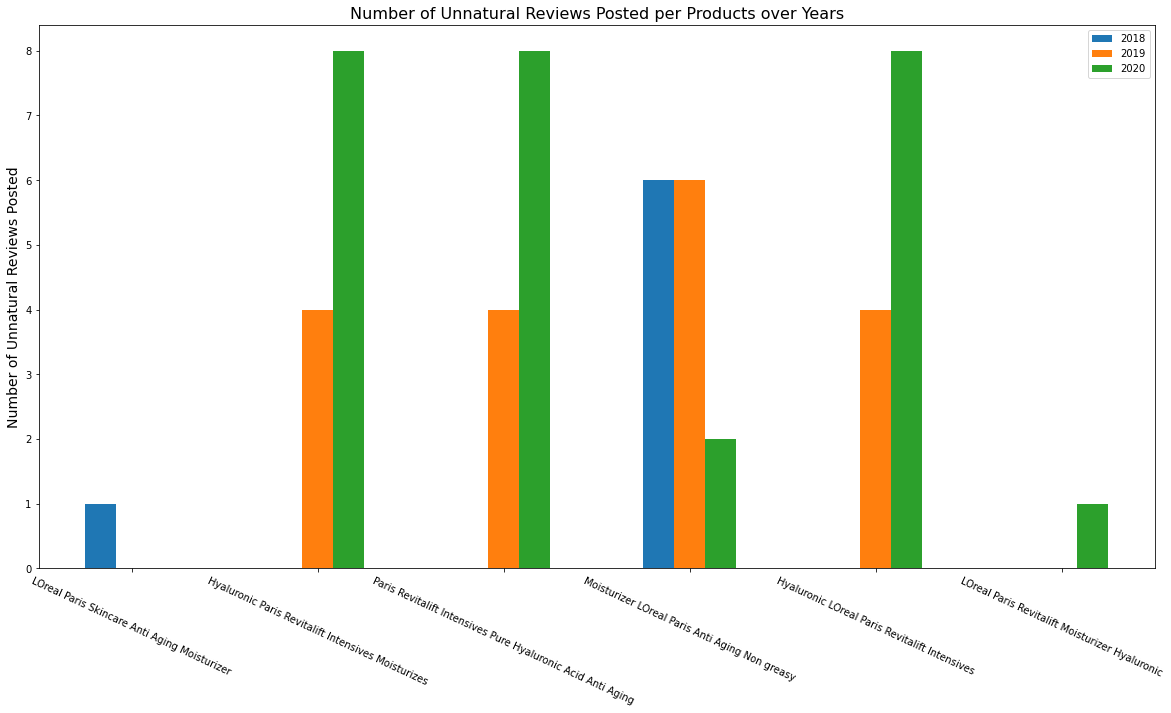

In [14]:
june_2018_df = june_2018_df.merge(products_df[['asin','name']])
july_2019_df = july_2019_df.merge(products_df[['asin','name']])
july_2020_df = july_2020_df.merge(products_df[['asin','name']])

june_2018_products = june_2018_df.groupby('name').size().reset_index(name='2018')
july_2019_products = july_2019_df.groupby('name').size().reset_index(name='2019')
july_2020_products = july_2020_df.groupby('name').size().reset_index(name='2020')

unique_names = list(set(list(june_2018_products['name']) + list(july_2019_products['name']) + list(july_2020_products['name'])))

final_count_df = pd.DataFrame()
final_count_df['name'] = unique_names

final_count_df = final_count_df.merge(june_2018_products, how='left',left_on='name', right_on='name')
final_count_df = final_count_df.merge(july_2019_products, how='left',left_on='name', right_on='name')
final_count_df = final_count_df.merge(july_2020_products, how='left',left_on='name', right_on='name')
final_count_df = final_count_df.fillna(0)
final_count_df['name'] = final_count_df['name'].str.replace('-',' ')

ax = final_count_df.plot(kind='bar',figsize=(20,10))
ax.set_ylabel('Number of Unnatural Reviews Posted', fontsize=14)
ax.set_title('Number of Unnatural Reviews Posted per Products over Years',  fontsize=16)
ax.set_xticklabels(list(final_count_df['name']),rotation = 335)
ax.legend()

plt.show()